# Dependency Installation

In [ ]:
# Uncomment if not installed already
# !pip install pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost tqdm

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
import os

warnings.filterwarnings("ignore")

# Load dataset

In [ ]:
# Load dataset manually from SystemDS-hosted UCI Adult data
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# Set this to True if you want to use the local copy fo the dataset
offline = False

train_url = "https://systemds.apache.org/assets/datasets/adult/train_data.csv" if offline else "data/train_data.csv"
test_url = "https://systemds.apache.org/assets/datasets/adult/test_data.csv" if offline else "data/test_data.csv"

train_df = pd.read_csv(train_url, names=column_names, na_values="?", skipinitialspace=True, header=0)
test_df = pd.read_csv(test_url, names=column_names, na_values="?", skipinitialspace=True, header=0)

# Concatenate for uniform preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)
df = df.dropna()

# Split features and target
le = LabelEncoder()
y = le.fit_transform(df["income"])
X = df.drop("income", axis=1)

# Identify feature types
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# EDA


--- Exploratory Data Analysis (EDA) ---


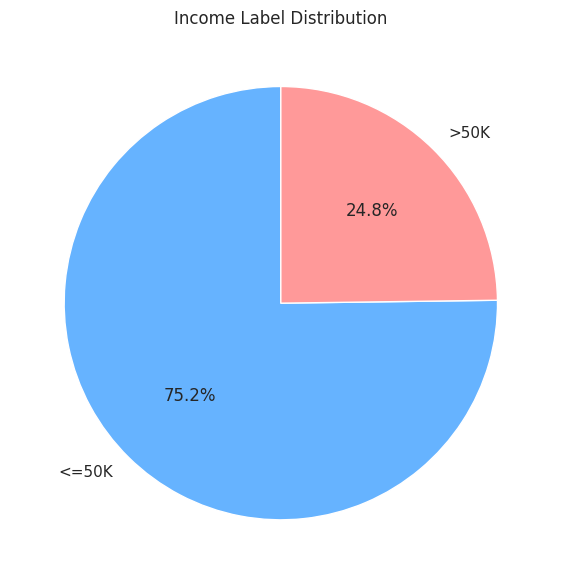

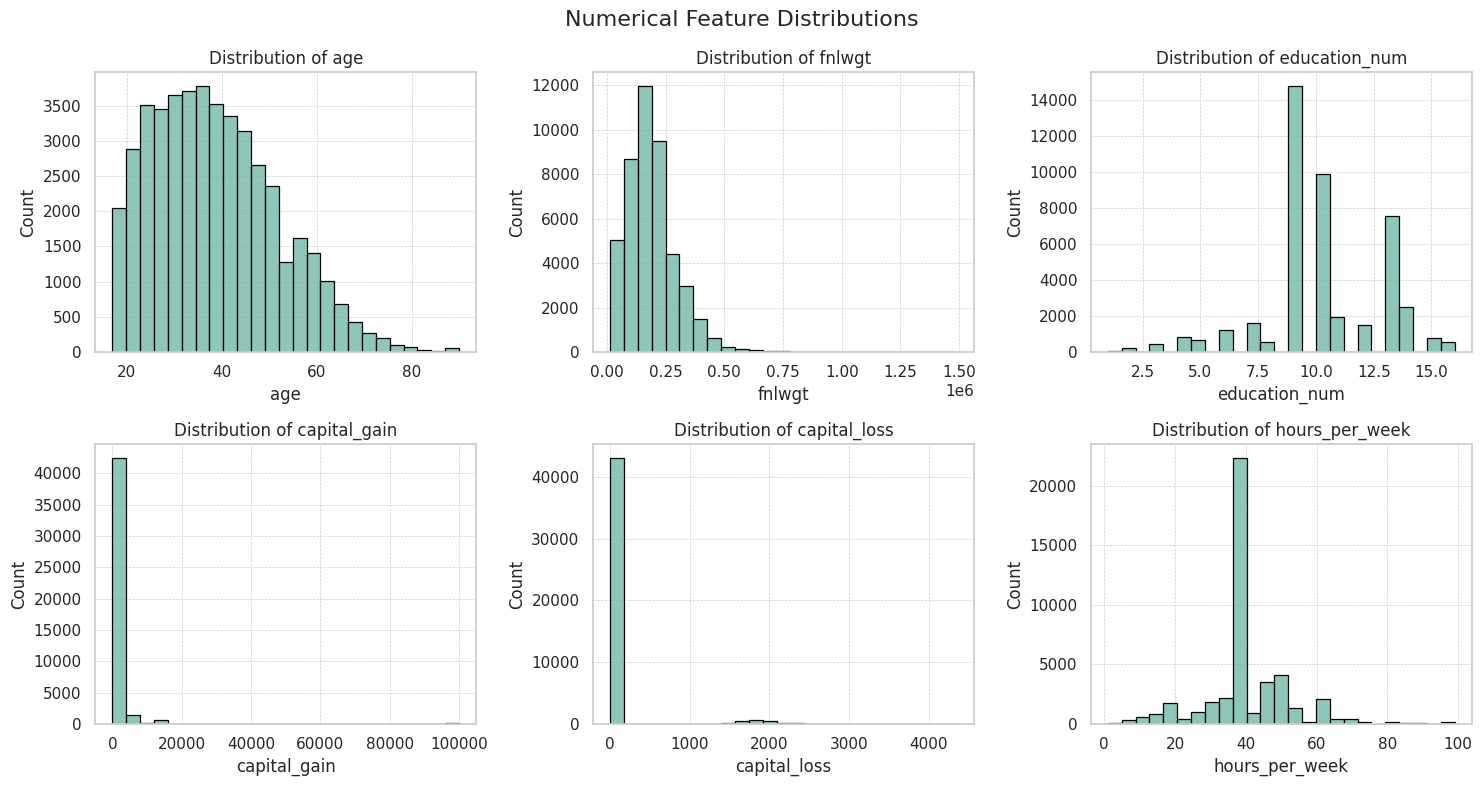

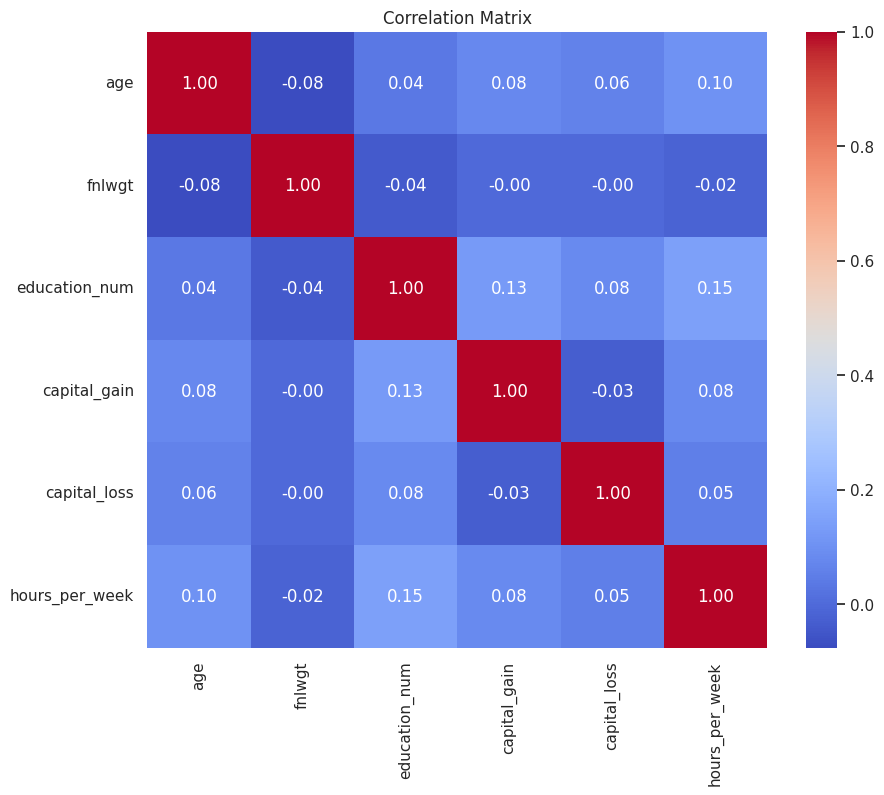

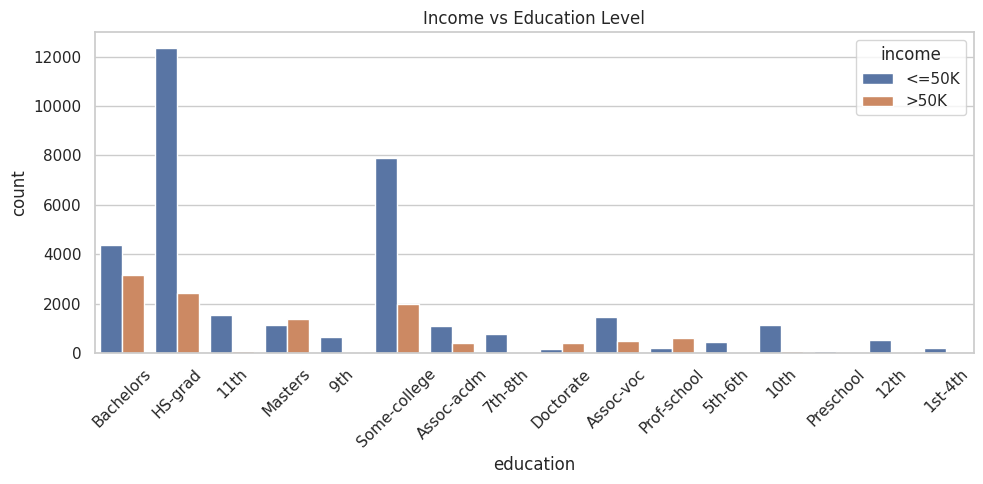

In [92]:
print("\n--- Exploratory Data Analysis (EDA) ---")

# 1. Label distribution (Pie Chart)
plt.figure(figsize=(6, 6))
df["income"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff9999"])
plt.title("Income Label Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 2. Numerical feature distributions with gaps and KDE overlays
num_cols = df.select_dtypes(include=np.number).columns
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, ax=axes[i], bins=25, color="#69b3a2", edgecolor="black")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].grid(True, linestyle="--", linewidth=0.5)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Numerical Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# 3. Correlation heatmap (numerical features only)
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 4. Income vs education level
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="education", hue="income")
plt.xticks(rotation=45)
plt.title("Income vs Education Level")
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

X_train_dense = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
X_test_dense = X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc

# Define noise addition functions

In [ ]:
def add_laplace_noise(X, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(loc=0.0, scale=scale, size=X.shape)
    return X + noise

def add_gaussian_noise(X, epsilon, delta=1e-5, sensitivity=0.1):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

# Calculate specificity (TNR)

In [ ]:
def specificity_score(y_true, y_pred, pos_label=1):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    tn, fp = cm[0, 0], cm[0, 1]
    return tn / (tn + fp)

# Experiment setup

In [ ]:
epsilon_values = [0.1, 0.5, 1.0, 2.0, 5.0]
mechanisms = ['Laplace', 'Gaussian']
models = ["Random Forest", "LightGBM", "XGBoost"]
rf = RandomForestClassifier()
lgbm = LGBMClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
results = []

# Baseline training

In [ ]:
print("Training baseline models...")
with tqdm(total=len(models), desc="Baseline Training") as pbar:
    for model_name, model in zip(models, [rf, lgbm, xgb]):
        model.fit(X_train_proc, y_train)
        preds = model.predict(X_test_proc)
        results.append({
            "Model": model_name,
            "Mechanism": "None",
            "Epsilon": "∞",
            "Accuracy": accuracy_score(y_test, preds),
            "Precision": precision_score(y_test, preds, pos_label=1),
            "Recall": recall_score(y_test, preds, pos_label=1),
            "F1": f1_score(y_test, preds, pos_label=1),
            "Specificity": specificity_score(y_test, preds)
        })
        pbar.update(1)

Training baseline models...


Baseline Training:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8406, number of negative: 25510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 33916, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247848 -> initscore=-1.110125
[LightGBM] [Info] Start training from score -1.110125


# DP training

In [ ]:
print("Training DP models...")
total_steps = len(mechanisms) * len(epsilon_values) * len(models)
with tqdm(total=total_steps, desc="DP Training") as pbar:
  for mech in mechanisms:
      for eps in epsilon_values:
          if mech == "Laplace":
              X_train_noisy = add_laplace_noise(X_train_dense, eps)
          else:
              X_train_noisy = add_gaussian_noise(X_train_dense, eps)

          # Random Forest
          dp_rf = RandomForestClassifier()
          dp_rf.fit(X_train_noisy, y_train)
          preds_rf = dp_rf.predict(X_test_dense)
          results.append({
              "Model": "Random Forest",
              "Mechanism": mech,
              "Epsilon": eps,
              "Accuracy": accuracy_score(y_test, preds_rf),
              "Precision": precision_score(y_test, preds_rf, pos_label=1),
              "Recall": recall_score(y_test, preds_rf, pos_label=1),
              "F1": f1_score(y_test, preds_rf, pos_label=1),
              "Specificity": specificity_score(y_test, preds_rf)
          })
          pbar.update(1)

          # LightGBM
          dp_lgbm = LGBMClassifier()
          dp_lgbm.fit(X_train_noisy, y_train)
          preds_lgbm = dp_lgbm.predict(X_test_dense)
          results.append({
              "Model": "LightGBM",
              "Mechanism": mech,
              "Epsilon": eps,
              "Accuracy": accuracy_score(y_test, preds_lgbm),
              "Precision": precision_score(y_test, preds_lgbm, pos_label=1),
              "Recall": recall_score(y_test, preds_lgbm, pos_label=1),
              "F1": f1_score(y_test, preds_lgbm, pos_label=1),
              "Specificity": specificity_score(y_test, preds_lgbm)
          })
          pbar.update(1)

          # XGBoost
          dp_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
          dp_xgb.fit(X_train_noisy, y_train)
          preds_xgb = dp_xgb.predict(X_test_dense)
          results.append({
              "Model": "XGBoost",
              "Mechanism": mech,
              "Epsilon": eps,
              "Accuracy": accuracy_score(y_test, preds_xgb),
              "Precision": precision_score(y_test, preds_xgb, pos_label=1),
              "Recall": recall_score(y_test, preds_xgb, pos_label=1),
              "F1": f1_score(y_test, preds_xgb, pos_label=1),
              "Specificity": specificity_score(y_test, preds_xgb)
          })
          pbar.update(1)

Training DP models...


DP Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 8406, number of negative: 25510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 33916, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247848 -> initscore=-1.110125
[LightGBM] [Info] Start training from score -1.110125
[LightGBM] [Info] Number of positive: 8406, number of negative: 25510
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26520
[LightGBM] [Info] Number of data points in the train set: 33916, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247848 -> initscore=-1.110125
[LightGBM] [Info] Start training from score -1.110125
[LightGBM]

# Convert to DataFrame

In [ ]:
result_df = pd.DataFrame(results)
result_df_filtered = result_df[result_df["Epsilon"] != "∞"]

# Plotting

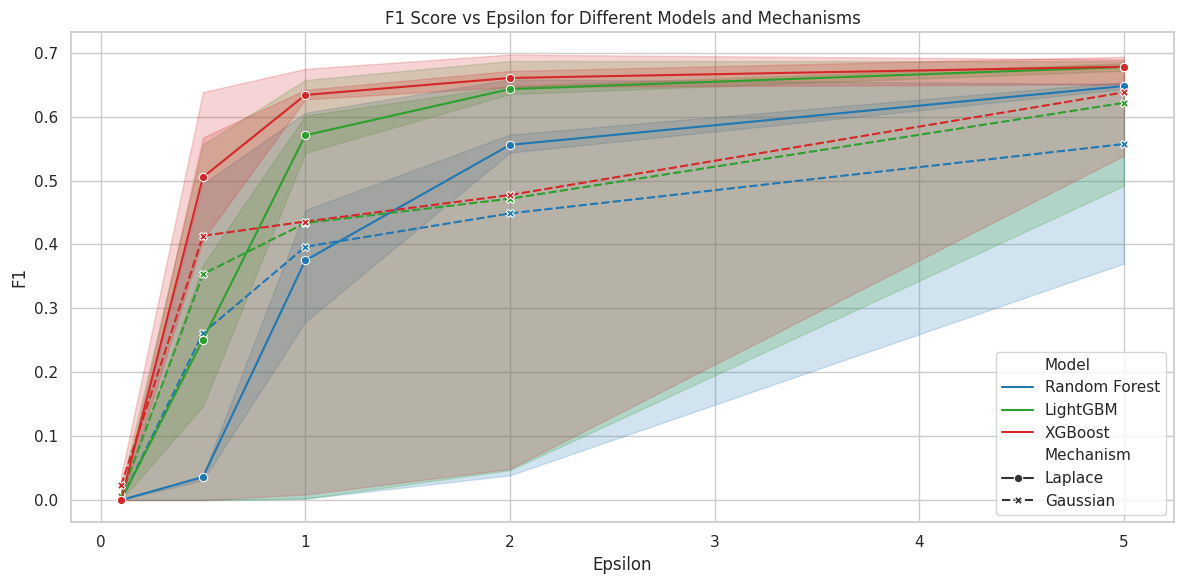

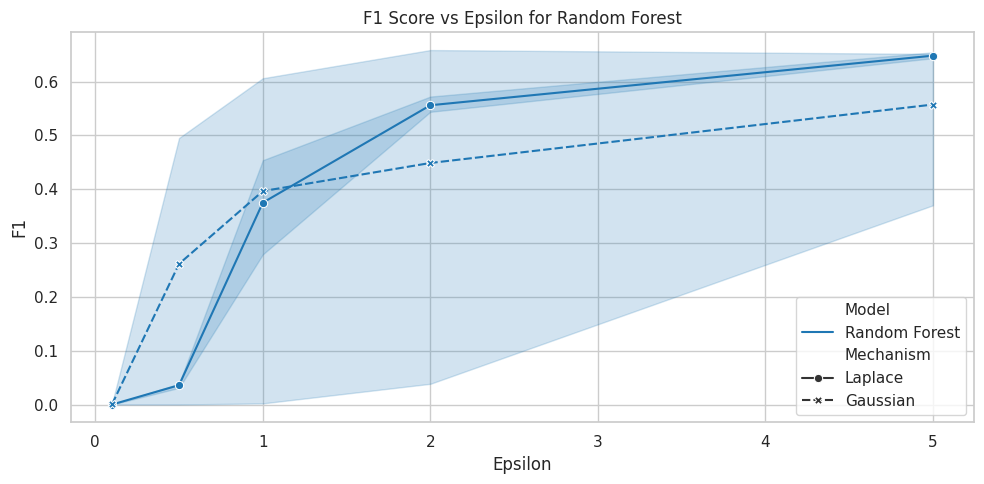

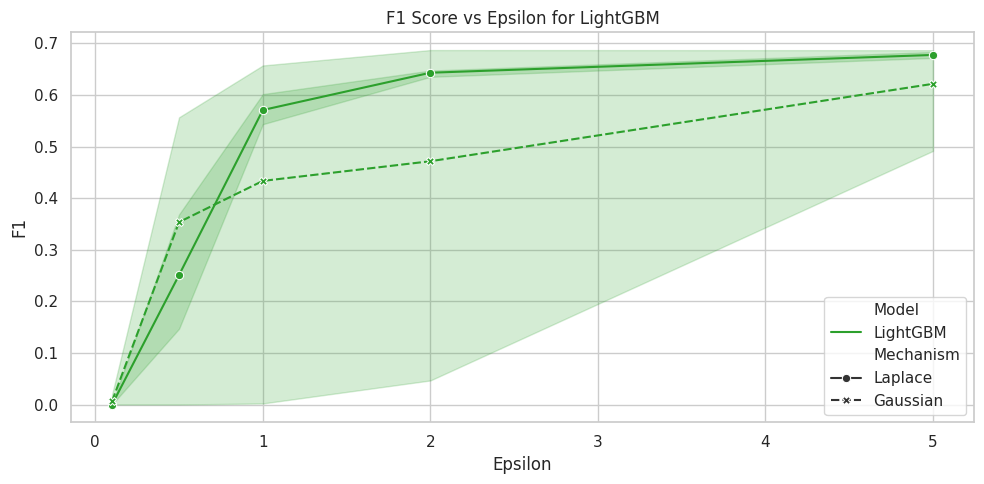

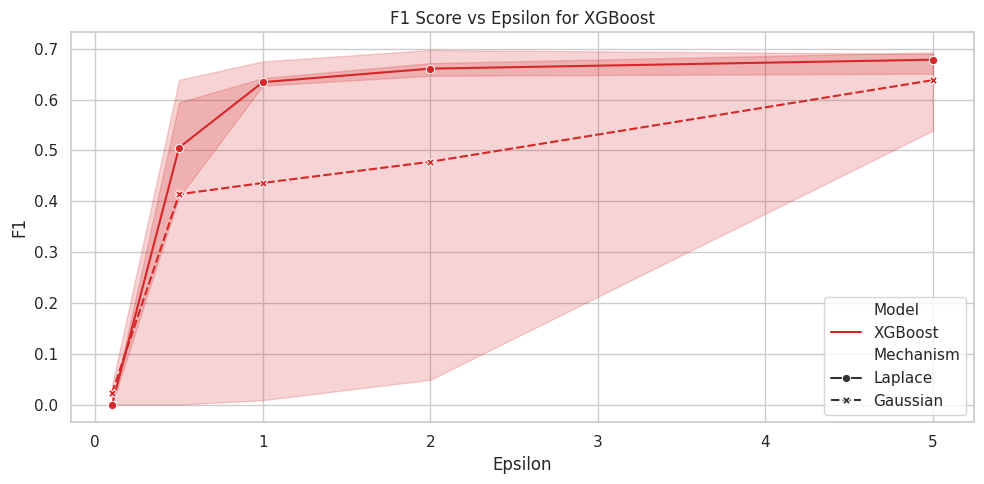

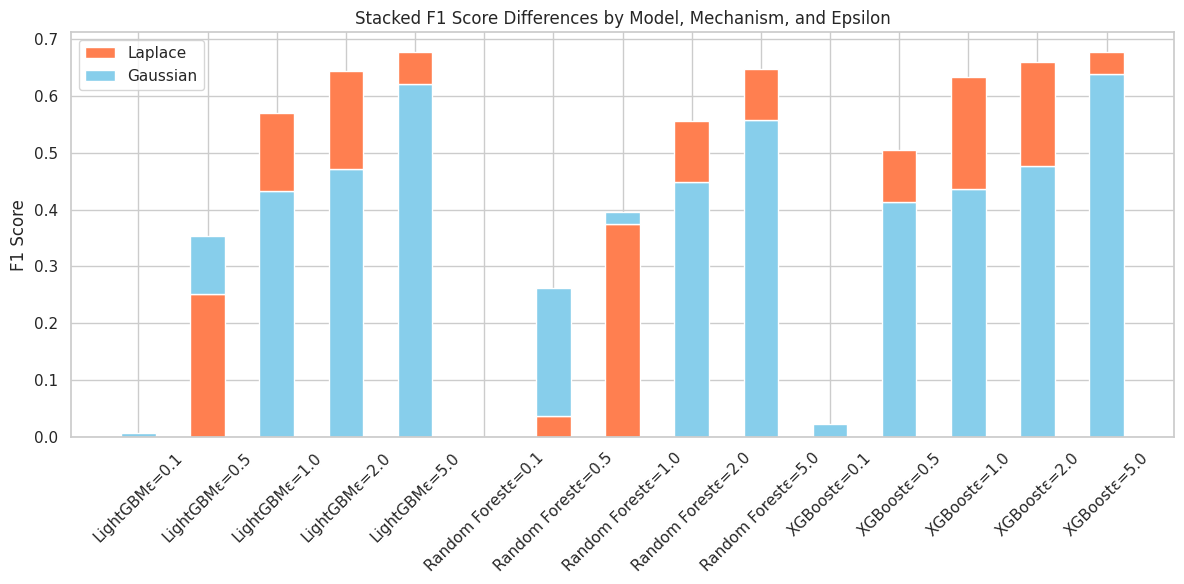

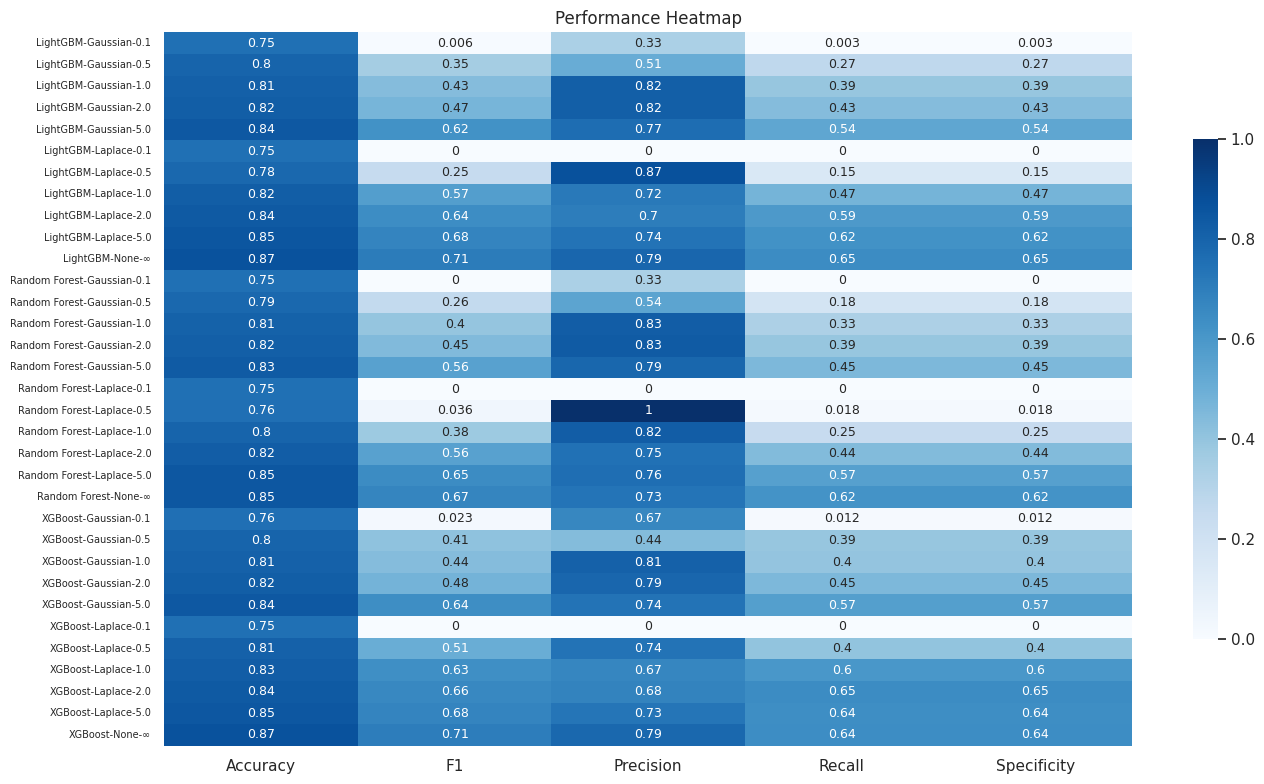

In [ ]:
sns.set(style="whitegrid")

# 1. Line chart: F1 vs Epsilon
model_palette = {
    "Random Forest": "#1f77b4",
    "LightGBM": "#2ca02c",
    "XGBoost": "#d62728"
}

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=result_df_filtered,
    x="Epsilon", y="F1",
    hue="Model", style="Mechanism", markers=True,
    palette=model_palette
)
plt.title("F1 Score vs Epsilon for Different Models and Mechanisms")
plt.tight_layout()
plt.show()

## Additional: Individual line charts per model
for model in result_df_filtered["Model"].unique():
    plt.figure(figsize=(10, 5))
    subset = result_df_filtered[result_df_filtered["Model"] == model]
    sns.lineplot(data=subset, x="Epsilon", y="F1", hue="Model", style="Mechanism", markers=True,
                 palette=[model_palette[model]] * subset["Mechanism"].nunique())
    plt.title(f"F1 Score vs Epsilon for {model}")
    plt.tight_layout()
    plt.show()

# 2. Bar chart: F1 per model across mechanisms (at epsilon=1.0)
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

## Pivot for stacked style
pivot_stacked = result_df_filtered.pivot_table(
    index=["Model", "Epsilon"],
    columns="Mechanism",
    values="F1"
).fillna(0)

## Sort index for consistency
pivot_stacked = pivot_stacked.sort_index()

## Determine base and top for stacking (shorter at base)
lap = pivot_stacked["Laplace"]
gauss = pivot_stacked["Gaussian"]
shorter = np.minimum(lap, gauss)
diff = np.abs(lap - gauss)
labels = [f"{m}ε={e}" for m, e in pivot_stacked.index.tolist()]

## Plot bars manually
x = np.arange(len(shorter))
bar_width = 0.5

plt.bar(x, shorter, width=bar_width,
        color=["coral" if lap[i] < gauss[i] else "skyblue" for i in range(len(lap))],
        label="Laplace")
plt.bar(x, diff, bottom=shorter, width=bar_width,
        color=["skyblue" if lap[i] < gauss[i] else "coral" for i in range(len(lap))],
        label="Gaussian")

plt.xticks(x, labels, rotation=45)
plt.ylabel("F1 Score")
plt.title("Stacked F1 Score Differences by Model, Mechanism, and Epsilon")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Heatmap
pivot_table = result_df.pivot_table(
    index=["Model", "Mechanism", "Epsilon"],
    values=["Accuracy", "Precision", "Recall", "F1", "Specificity"]
)

## Flatten multi-index to single string label for y-axis
pivot_table.index = pivot_table.index.map(lambda x: f"{x[0]}-{x[1]}-{x[2]}")

plt.figure(figsize=(14, 8))
ax = sns.heatmap(pivot_table.round(3), annot=True, cmap="Blues",
                 annot_kws={"size": 9}, cbar_kws={"shrink": 0.7})
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
plt.title("Performance Heatmap", fontsize=12)
plt.tight_layout()
plt.show()
